In [2]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
#env = gym.make('FrozenLake8x8-v0', is_slippery=False)
env = gym.make('FrozenLake-v0', is_slippery=True)
print (env)

<TimeLimit<FrozenLakeEnv<FrozenLake-v0>>>


In [4]:
aaa =env.reset()
env.render()
print (aaa)


SFFF
FHFH
FFFH
HFFG
0


In [5]:
env.reset()
env.render()
new_state, reward, done, info  = env.step(0)
env.render()
print ('Reward', reward, info, done)



SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
Reward 0.0 {'prob': 0.3333333333333333} False


In [62]:
# Method 1 : Value Iteration
def vi(env, disc=0.99, eps = 1e-5):
    t0 = time.time()
    iterations = 0
    num_spaces = env.observation_space.n
    num_actions = env.action_space.n
    policy = np.zeros((num_spaces, 1))
    change = 1
    val_list = np.zeros((num_spaces, 1))
    old_list = val_list.copy()
    while change>eps:
        iterations = iterations+1
        for space in range(num_spaces):
            current_val = -np.inf
            for action in range(num_actions):
                total_val = 0
                for prob, new_state, reward, complete in env.P[space][action]:
                #    print (space, action, ' ~~~ ' , prob, new_state, reward, complete)
                    if (complete == True and reward!=1):
                        reward = -0.75 #penalty for holes
                    val = 0
                    new_val = old_list[new_state][0]
                    if (complete):
                        val = reward
                    else:
                        val = reward + disc*new_val
                    total_val = total_val + val*prob
                    
                if (total_val > current_val):
                    current_val = total_val
                    policy[space][0] = action
                    val_list[space][0] = current_val
                    
        changes = np.abs(val_list - old_list)
        change = np.max(changes)
        old_list = val_list.copy()
                    
    runtime = time.time() - t0
    return iterations, policy, runtime

In [7]:
# Method 2 : Policy Iteration
def pi(env, disc=0.99, eps = 1e-5):
    t0 = time.time()
    num_spaces = env.observation_space.n
    num_actions = env.action_space.n
    policy = np.random.randint(num_actions, size=(num_spaces, 1))
    val_list = np.zeros((num_spaces, 1))
    
    iterations = 0
 #   policy = []
    runtime = 0
    
    stable = False
    
    while not stable:
        iterations = iterations + 1
        evaluation_acc = True
        
        while evaluation_acc:
            eps_val=0
            for s in range(num_spaces):
                value = val_list[s][0]
                pol = policy[s][0]
                
                total_val_new = 0
                for prob, new_state, reward, complete in env.P[s][pol]:
                    val_new_state = val_list[new_state][0]
                    temp_val = 0
                    if complete:
                        temp_val = reward
                    else:
                        temp_val = reward + val_new_state*disc
                    total_val_new = total_val_new + temp_val*prob
                val_list[s][0] = total_val_new
                eps_val = max(np.abs(value-val_list[s][0]), eps_val)
            if (eps_val < eps):
                evaluation_acc = False
                
        stable = True
        for s in range(num_spaces):
            old_act = policy[s][0]
            max_val = -np.inf
            for act in range(num_actions):
                total_temp_val = 0 
                for prob, new_state, reward, done in env.P[s][act]:
                    
                    val_new_state = val_list[new_state][0]
                    temp_val = 0
                    if complete:
                        temp_val = reward
                    else:
                        temp_val = reward + val_new_state*disc
                    total_val_new = total_val_new + temp_val*prob
                    
                if (total_temp_val > max_val):
                    max_val = total_temp_val
                    policy[s][0] = act
            
            print ('+++++.  ', old_act, policy[s][0])
            if(old_act != policy[s][0]):
                stable = False
    
    runtime = time.time() - t0
    return iterations, policy, runtime

In [8]:
def compute_policy_v(env, policy, gamma, eps):
    v = np.zeros(env.nS)
#    eps = 1e-5
    while True:
        prev_v = np.copy(v)
        for s in range(env.nS):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, is_done in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            break
    return v

def extract_policy(env,v, gamma):
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        q_sa = np.zeros(env.nA)
        for a in range(env.nA):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in  env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy

def pi2 (env, disc=0.99, eps = 1e-5):
    t0 = time.time()
    policy = np.random.choice(env.nA, size=(env.nS))  
    max_iters = 2000
    for i in range(max_iters):
        old_policy_v = compute_policy_v(env, policy, disc, eps)
        new_policy = extract_policy(env,old_policy_v, eps)
        if (np.all(policy == new_policy)):
            k=i+1
            break
        policy = new_policy
    pi_time_val = time.time() - t0
    return k, policy, pi_time_val

In [71]:
def ql(env, alpha=0.9, gamma=0.99, eps=0.9, episodes = 100):
    t0 = time.time()
    num_spaces = env.observation_space.n
    num_actions = env.action_space.n
    
    Q = np.zeros((num_spaces, num_actions))
    rewards = []
    iters = []
    best_policy = [0]*num_spaces
    
    for episode in range(episodes):
        #print ('\n', episode)
        state = env.reset()
        done = False
        max_steps = 1000
        total_reward = 0
        for i in range(max_steps):
            if done:
                break
            
            current = state
            if (np.random.rand() < eps):
                action = np.argmax(Q[current, :])
            else:
                action = env.action_space.sample()
                    
            state, reward, done, info = env.step(action)
            if (done == True and reward!=1):
                reward = -0.75 #penalty for holes
            total_reward = total_reward+reward
            Q[current, action] = (1-alpha)*Q[current, action] + alpha * (reward + gamma * np.max(Q[state, :]))
        rewards.append(total_reward)
        #print (i)
        iters.append(i)
    
        for j in range(num_spaces):
            best_policy[j] = np.argmax(Q[j, :])
    
    q_solve_iter = np.mean(iters)
    avg_reward = np.mean(rewards)
    ql_time_val = time.time() - t0
    return best_policy, q_solve_iter, ql_time_val, Q, avg_reward

In [10]:
best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env, alpha=0.9, gamma=0.99, eps=0.9, episodes = 100)
print (best_policy)
print (Q)
print (q_solve_iter, ql_time_val, avg_reward)


 0
10

 1
5

 2
8

 3
7

 4
11

 5
33

 6
14

 7
79

 8
10

 9
45

 10
25

 11
18

 12
22

 13
10

 14
22

 15
48

 16
8

 17
6

 18
20

 19
44

 20
44

 21
13

 22
7

 23
43

 24
14

 25
37

 26
11

 27
15

 28
6

 29
20

 30
75

 31
35

 32
8

 33
10

 34
38

 35
4

 36
24

 37
12

 38
42

 39
31

 40
15

 41
38

 42
19

 43
18

 44
31

 45
31

 46
13

 47
12

 48
7

 49
22

 50
5

 51
6

 52
27

 53
2

 54
12

 55
26

 56
8

 57
25

 58
48

 59
3

 60
30

 61
26

 62
9

 63
27

 64
23

 65
30

 66
56

 67
27

 68
18

 69
16

 70
16

 71
12

 72
15

 73
2

 74
7

 75
41

 76
43

 77
8

 78
24

 79
10

 80
37

 81
9

 82
11

 83
32

 84
2

 85
4

 86
2

 87
21

 88
13

 89
4

 90
14

 91
57

 92
32

 93
16

 94
36

 95
35

 96
80

 97
10

 98
61

 99
3
[3, 3, 3, 3, 0, 0, 2, 0, 3, 1, 3, 0, 0, 2, 2, 0]
[[-0.0913123   0.04443979  0.04131828  0.08433533]
 [-0.74868639 -0.01600672 -0.65005246  0.08507678]
 [-0.64893589  0.0107146  -0.02755757  0.04978606]
 [-0.0099456   0.04309823 -0.0459

In [19]:
def get_rewards_iters(env, policy, epochs = 100):
    rewards = []
    iters = []
    
    for i in range(epochs):
        state = env.reset()
        n_iters = 0
        done = False
        each_epoch_reward = 0
        completed = False
        while not completed and n_iters<1000:
            n_iters = n_iters + 1
            action = int(policy[state])
            new_state, reward, done, _ = env.step(action)
            each_epoch_reward = each_epoch_reward + reward
            state = new_state
            if (done == True and reward == 1):
                completed = True
            
        rewards.append(each_epoch_reward)
        iters.append(n_iters)
    
    avg_rewards = np.mean(rewards)
    avg_iters = np.mean(iters)
    
    return avg_rewards, avg_iters
    


In [25]:
disc_rate = [0.5, 0.7, 0.9, 0.99, 0.999]
eps = [1e-15, 1e-13, 1e-11,1e-9, 1e-7,1e-5, 1e-3, 1e-1, 0.2]
vi_iter = np.zeros((len(disc_rate), len(eps)))
vi_policy =  {}
vi_time = np.zeros((len(disc_rate), len(eps)))
vi_reward = np.zeros((len(disc_rate), len(eps)))
vi_episode = np.zeros((len(disc_rate), len(eps)))

pi_iter = np.zeros((len(disc_rate), len(eps)))
pi_policy = {}
pi_time = np.zeros((len(disc_rate), len(eps)))
pi_reward = np.zeros((len(disc_rate), len(eps)))
pi_episode = np.zeros((len(disc_rate), len(eps)))

ql_iter = np.zeros((len(disc_rate), len(eps)))
ql_policy = {}
ql_time = np.zeros((len(disc_rate), len(eps)))
ql_reward = np.zeros((len(disc_rate), len(eps)))
ql_episode = np.zeros((len(disc_rate), len(eps)))
ql_qarray = np.zeros((len(disc_rate), len(eps)))
ql_rewards = np.zeros((len(disc_rate), len(eps)))


for i in range(len(disc_rate)):
#for i in range(1):
    #print ('\n i ', i)
    vi_policy[i]={}
    pi_policy[i]={}
    for j in range(len(eps)):
    #for j in range(1):
        print ('   j ', j)
        vi_policy[i][j] = {}
        vi_iter_val, vi_policy_val, vi_time_val = vi(env, disc_rate[i], eps[j])
        #print ('  VI => ', vi_iter_val, vi_time_val)
        #print (vi_policy_val)
        vi_reward_val, vi_episode_val = get_rewards_iters(env, vi_policy_val, epochs = 100)
        print (vi_reward_val, vi_episode_val)
        vi_iter[i][j]    = vi_iter_val
        vi_policy[i][j]  = vi_policy_val
        vi_time[i][j]    = vi_time_val
        vi_reward[i][j]  = vi_reward_val
        vi_episode[i][j] = vi_episode_val
        
        pi_policy[i][j] = {}
        
        #print ('PI2 --- ')
        pi_iter_val, pi_policy_val, pi_time_val = pi2(env, disc_rate[i], eps[j])
        pi_reward_val, pi_episode_val = get_rewards_iters(env, pi_policy_val, epochs = 100)
        #print (policy)
        #print (pi_reward_val, pi_episode_val)
        pi_iter[i][j]    = pi_iter_val
        pi_policy[i][j]  = pi_policy_val
        pi_time[i][j]    = pi_time_val
        pi_reward[i][j]  = pi_reward_val
        pi_episode[i][j] = pi_episode_val
        
        
        
        

   j  0
0.43 583.24
   j  1
0.42 590.94
   j  2
0.52 494.05
   j  3
0.55 465.87
   j  4
0.45 563.98
   j  5
0.47 546.37
   j  6
0.45 564.64
   j  7
0.0 1000.0
   j  8
0.0 1000.0
   j  0
0.45 563.4
   j  1
0.48 534.25
   j  2
0.5 515.06
   j  3
0.44 572.94
   j  4
0.42 593.52
   j  5
0.55 469.45
   j  6
0.38 630.94
   j  7
0.0 1000.0
   j  8
0.0 1000.0
   j  0
0.73 304.25
   j  1
0.81 221.06
   j  2
0.89 143.5
   j  3
0.78 252.28
   j  4
0.83 205.04
   j  5
0.77 268.27
   j  6
0.68 348.44
   j  7
0.0 1000.0
   j  8
0.0 1000.0
   j  0
0.78 259.92
   j  1
0.81 229.69
   j  2
0.9 143.48
   j  3
0.85 184.77
   j  4
0.82 219.74
   j  5
0.86 178.28
   j  6
0.81 228.8
   j  7
0.0 1000.0
   j  8
0.0 1000.0
   j  0
0.83 211.93
   j  1
0.87 170.53
   j  2
0.81 224.63
   j  3
0.85 197.04
   j  4
0.84 202.77
   j  5
0.84 201.77
   j  6
0.85 191.63
   j  7
0.0 1000.0
   j  8
0.0 1000.0


In [24]:
print (disc_rate)
print (eps)
print (vi_iter)

print (type(vi_iter))
print ((vi_iter.shape))


print (vi_iter[0,0:3])
print (vi_iter[0:2,0])

#fig = plt.figure(2)
#plt.plot(eps, vi_iter[0][:], label="a1")

print ('\n', vi_reward)
print ('\n', vi_episode)

[0.5, 0.7, 0.9, 0.99, 0.999]
[1e-05, 1e-13, 1e-11, 1e-09, 1e-07, 1e-05, 0.001, 0.1, 0.2]
[[  13.   37.   31.   25.   19.   13.    7.    2.    2.]
 [  22.   67.   56.   44.   33.   22.   11.    2.    2.]
 [  61.  196.  162.  129.   95.   61.   27.    2.    2.]
 [ 238.  770.  637.  504.  371.  238.  105.    3.    2.]
 [ 324. 1044.  864.  684.  504.  324.  144.    3.    2.]]
<class 'numpy.ndarray'>
(5, 9)
[13. 37. 31.]
[13. 22.]

 [[0.49 0.52 0.45 0.49 0.46 0.48 0.43 0.   0.  ]
 [0.48 0.4  0.47 0.54 0.41 0.48 0.46 0.   0.  ]
 [0.78 0.81 0.72 0.7  0.76 0.83 0.76 0.   0.  ]
 [0.82 0.82 0.82 0.8  0.85 0.78 0.85 0.   0.  ]
 [0.87 0.77 0.8  0.84 0.85 0.78 0.83 0.   0.  ]]

 [[ 524.64  496.64  563.04  524.01  552.57  534.56  582.76 1000.   1000.  ]
 [ 533.72  612.59  544.21  477.68  601.54  532.55  553.37 1000.   1000.  ]
 [ 258.32  219.32  316.25  330.09  275.64  213.72  271.67 1000.   1000.  ]
 [ 216.83  219.42  227.81  237.38  189.45  267.94  196.1  1000.   1000.  ]
 [ 180.24  265.7   239.47

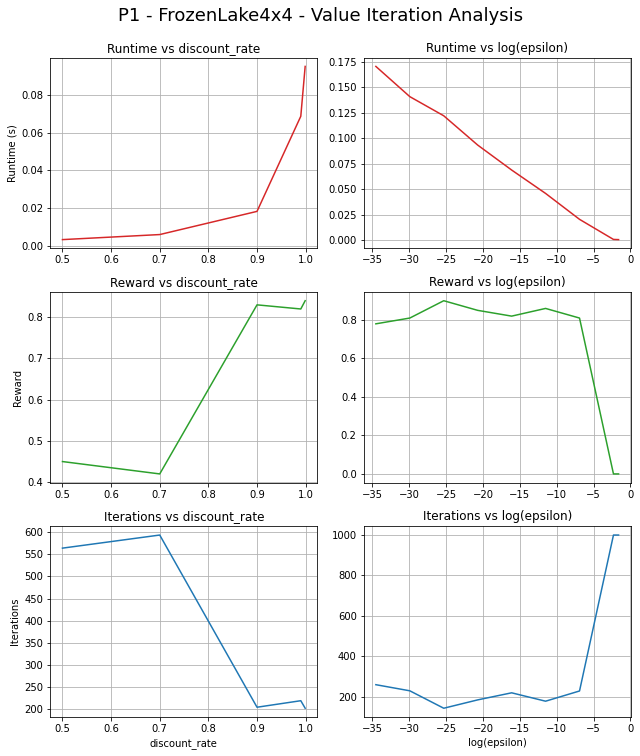

In [118]:
disc_rate = [0.5, 0.7, 0.9, 0.99, 0.999]
eps = [1e-15, 1e-13, 1e-11,1e-9, 1e-7,1e-5, 1e-3, 1e-1, 0.2]
fig, axs = plt.subplots(3,2, figsize=(9,11))
axs[0, 0].plot(disc_rate, vi_time[:,4], 'tab:red')
axs[0, 0].set_title('Runtime vs discount_rate')
axs[0, 0].set(ylabel='Runtime (s)')
axs[0, 0].grid()
axs[0, 1].plot(np.log(eps), vi_time[3,:], 'tab:red')
axs[0, 1].set_title('Runtime vs log(epsilon)')
axs[0, 1].grid()

axs[1, 0].plot(disc_rate, vi_reward[:,4], 'tab:green')
axs[1, 0].set_title('Reward vs discount_rate')
axs[1, 0].set(ylabel='Reward')
axs[1, 0].grid()
axs[1, 1].plot(np.log(eps), vi_reward[3,:], 'tab:green')
axs[1, 1].set_title('Reward vs log(epsilon)')
axs[1, 1].grid()

axs[2, 0].plot(disc_rate, vi_episode[:,4], 'tab:blue')
axs[2, 0].set_title('Iterations vs discount_rate')
axs[2, 0].set(xlabel='discount_rate')
axs[2, 0].set(ylabel='Iterations')
axs[2, 0].grid()
axs[2, 1].plot(np.log(eps), vi_episode[3,:], 'tab:blue')
axs[2, 1].set_title('Iterations vs log(epsilon)')
axs[2, 1].set(xlabel='log(epsilon)')
axs[2, 1].grid()



fig.suptitle('P1 - FrozenLake4x4 - Value Iteration Analysis', fontsize=18)

#plt.legend()
#plt.ylim(0, 5e-6)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [97]:
# plot policy
def plot_policy(size, policy):
    name = str(size)+'x'+str(size)
    discrete_map = np.array([[-1,-1,-1,-1],[-1, 0, -1, 0],[-1,-1,-1, 0],[0, -1,-1, 1]])
    plt.imshow(discrete_map, cmap='brg')
    
    
    policy_reshape = policy.reshape((size, size))
    
    for i in range(size):
        for j in range(size):
            if policy_reshape[i][j]==0:
                arrow = '\u2190'
            elif policy_reshape[i][j]==1:
                arrow = '\u2193'
            elif policy_reshape[i][j]== 2:
                arrow = '\u2192'
            else:
                arrow = '\u2191'
            plotText = plt.text(j, i, arrow, ha="center", va="center", color="w", size=15)    
    plt.title('FrozenLake 4x4 Best Policy ')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()

[[0.]
 [3.]
 [3.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]
 [3.]
 [1.]
 [0.]
 [0.]
 [0.]
 [2.]
 [1.]
 [0.]]


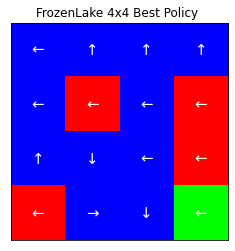

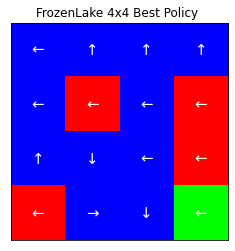

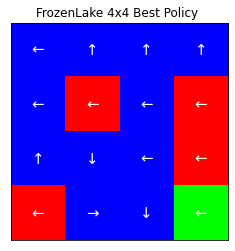

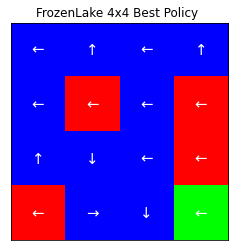

In [98]:
print ((vi_policy[3][4]))
plot_policy(4, vi_policy[3][4])
plot_policy(4, vi_policy[3][3])
plot_policy(4, vi_policy[3][2])
plot_policy(4, pi_policy[2][4])

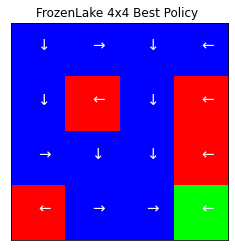

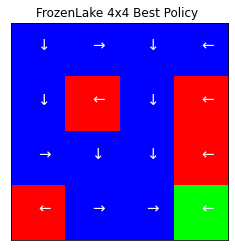

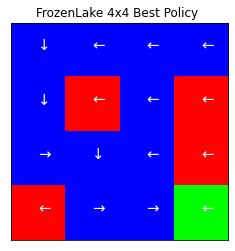

In [79]:
env1 = gym.make('FrozenLake-v0', is_slippery=False)
vi_iter_val, vi_policy_val, vi_time_val = vi(env1, 0.99, 1e-7)
plot_policy(4, vi_policy_val)
pi_iter_val, pi_policy_val, pi_time_val = pi2(env1, 0.99, 1e-7)
plot_policy(4, pi_policy_val)
best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env1, alpha=0.9, gamma=0.99, eps=0.9, episodes = 100)
plot_policy(4, np.array(best_policy))

In [67]:
print ((best_policy))

[2, 3, 3, 3, 0, 0, 1, 0, 3, 1, 0, 0, 0, 2, 1, 0]


In [69]:
aaa = np.array(best_policy).reshape(4,4)

In [70]:
print (aaa)

[[2 3 3 3]
 [0 0 1 0]
 [3 1 0 0]
 [0 2 1 0]]


In [81]:
print (disc_rate)
print (eps)
print (pi_iter)

print (type(vi_iter))
print ((vi_iter.shape))

#fig = plt.figure(2)
#plt.plot(eps, vi_iter[0][:], label="a1")

print ('\n', pi_reward)
print ('\n', pi_episode)

[0.5, 0.7, 0.9, 0.99, 0.999]
[1e-15, 1e-13, 1e-11, 1e-09, 1e-07, 1e-05, 0.001, 0.1, 0.2]
[[4. 5. 3. 5. 6. 3. 3. 2. 2.]
 [4. 4. 5. 3. 5. 4. 5. 3. 3.]
 [4. 4. 2. 6. 3. 6. 3. 4. 3.]
 [4. 3. 7. 7. 4. 7. 3. 3. 4.]
 [4. 4. 4. 7. 4. 7. 4. 4. 5.]]
<class 'numpy.ndarray'>
(5, 9)

 [[0.39 0.49 0.43 0.43 0.49 0.37 0.5  0.2  0.  ]
 [0.53 0.44 0.45 0.44 0.4  0.46 0.41 0.11 0.24]
 [0.79 0.79 0.78 0.76 0.79 0.74 0.76 0.42 0.27]
 [0.81 0.81 0.81 0.83 0.79 0.86 0.79 0.73 0.4 ]
 [0.81 0.76 0.78 0.82 0.76 0.86 0.72 0.84 0.35]]

 [[ 621.76  524.5   583.87  583.18  526.06  641.81  515.68  803.65 1000.  ]
 [ 484.83  572.17  563.44  572.01  612.08  552.83  601.79  892.26  765.63]
 [ 247.9   246.01  248.56  274.47  243.65  294.49  271.87  593.04  734.34]
 [ 233.68  231.81  232.03  214.22  244.98  178.68  246.44  299.02  612.02]
 [ 235.95  278.46  254.53  220.    276.09  182.86  318.36  194.49  661.42]]


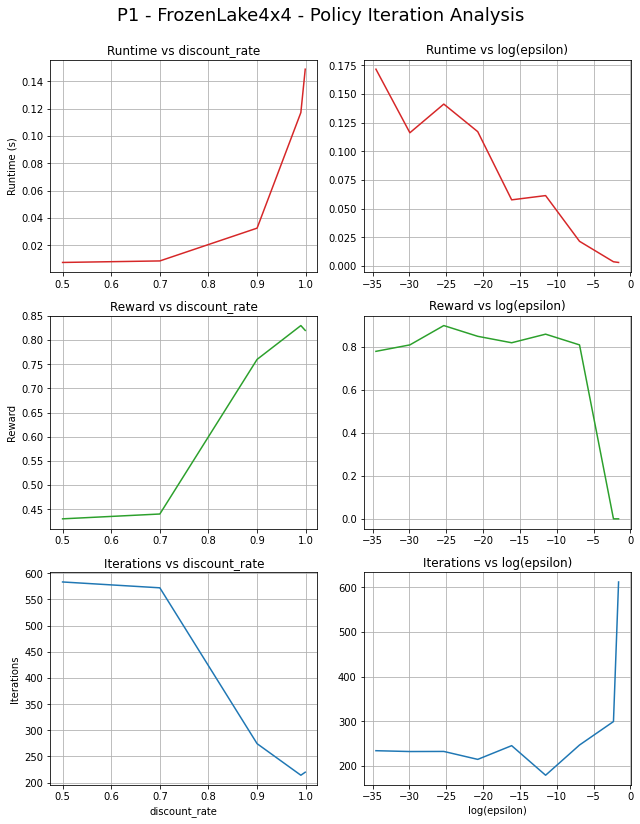

In [119]:
disc_rate = [0.5, 0.7, 0.9, 0.99, 0.999]
eps = [1e-15, 1e-13, 1e-11,1e-9, 1e-7,1e-5, 1e-3, 1e-1, 0.2]
fig, axs = plt.subplots(3,2, figsize=(9,12))
axs[0, 0].plot(disc_rate, pi_time[:,3], 'tab:red')
axs[0, 0].set_title('Runtime vs discount_rate')
axs[0, 0].set(ylabel='Runtime (s)')
axs[0, 0].grid()
axs[0, 1].plot(np.log(eps), pi_time[3,:], 'tab:red')
axs[0, 1].set_title('Runtime vs log(epsilon)')
axs[0, 1].grid()

axs[1, 0].plot(disc_rate, pi_reward[:,3], 'tab:green')
axs[1, 0].set_title('Reward vs discount_rate')
axs[1, 0].set(ylabel='Reward')
axs[1, 0].grid()
axs[1, 1].plot(np.log(eps), vi_reward[3,:], 'tab:green')
axs[1, 1].set_title('Reward vs log(epsilon)')
axs[1, 1].grid()

axs[2, 0].plot(disc_rate, pi_episode[:,3], 'tab:blue')
axs[2, 0].set_title('Iterations vs discount_rate')
axs[2, 0].set(xlabel='discount_rate')
axs[2, 0].set(ylabel='Iterations')
axs[2, 0].grid()
axs[2, 1].plot(np.log(eps), pi_episode[3,:], 'tab:blue')
axs[2, 1].set_title('Iterations vs log(epsilon)')
axs[2, 1].set(xlabel='log(epsilon)')
axs[2, 1].grid()



fig.suptitle('P1 - FrozenLake4x4 - Policy Iteration Analysis', fontsize=18)

#plt.legend()
#plt.ylim(0, 5e-6)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [86]:
disc_rate = [0.5, 0.7, 0.9, 0.99, 0.999]
eps = [1e-15, 1e-13, 1e-11,1e-9, 1e-7,1e-5, 1e-3, 1e-1, 0.2]
alpha = [0.5, 0.7, 0.9, 0.99]
gamma = [0.8, 0.9, 0.99, 0.999 ]
eps = [0.5, 0.7, 0.9, 0.99]
episode = [10, 50, 100, 500, 1000]


ql_iter = np.zeros((len(disc_rate), len(eps)))
ql_policy = {}
ql_time = np.zeros((len(disc_rate), len(eps)))
ql_reward = np.zeros((len(disc_rate), len(eps)))
ql_episode = np.zeros((len(disc_rate), len(eps)))
ql_qarray = np.zeros((len(disc_rate), len(eps)))
ql_rewards = np.zeros((len(disc_rate), len(eps)))

alpha_var = np.zeros((len(alpha), 3))
gamma_var = np.zeros((len(gamma), 3))
epsilon_var = np.zeros((len(eps), 3))
episode_var = np.zeros((len(episode), 3))

print ('1')
for i in range(len(alpha)):
    best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env1, alpha=alpha[i], gamma=0.99, eps=0.9, episodes = 100)
    alpha_var[i,0] = ql_time_val
    alpha_var[i,1] = avg_reward
    alpha_var[i,2] = q_solve_iter
print ('2')    
for i in range(len(gamma)):
    best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env1, alpha=0.9, gamma=gamma[i], eps=0.9, episodes = 100)
    gamma_var[i,0] = ql_time_val
    gamma_var[i,1] = avg_reward
    gamma_var[i,2] = q_solve_iter
print ('3')
for i in range(len(eps)):
    best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env1, alpha=0.9, gamma=0.99, eps=eps[i], episodes = 100)
    epsilon_var[i,0] = ql_time_val
    epsilon_var[i,1] = avg_reward
    epsilon_var[i,2] = q_solve_iter
print ('4')   
for i in range(len(episode)):
    best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env1, alpha=0.9, gamma=0.99, eps=0.9, episodes = episode[i])
    episode_var[i,0] = ql_time_val
    episode_var[i,1] = avg_reward
    episode_var[i,2] = q_solve_iter 
    
    

1
2
3
4


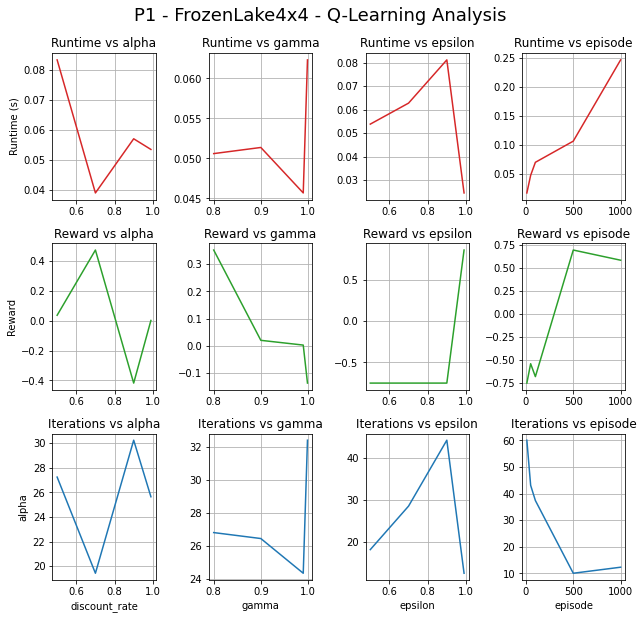

In [90]:
alpha = [0.5, 0.7, 0.9, 0.99]
gamma = [0.8, 0.9, 0.99, 0.999 ]
eps = [0.5, 0.7, 0.9, 0.99]
episode = [10, 50, 100, 500, 1000]

fig, axs = plt.subplots(3,4, figsize=(9,9))
axs[0, 0].plot(alpha, alpha_var[:,0], 'tab:red')
axs[0, 0].set_title('Runtime vs alpha')
axs[0, 0].set(ylabel='Runtime (s)')
axs[0, 0].grid()
axs[0, 1].plot(gamma, gamma_var[:,0], 'tab:red')
axs[0, 1].set_title('Runtime vs gamma')
axs[0, 1].grid()
axs[0, 2].plot(eps, epsilon_var[:,0], 'tab:red')
axs[0, 2].set_title('Runtime vs epsilon')
axs[0, 2].grid()
axs[0, 3].plot(episode, episode_var[:,0], 'tab:red')
axs[0, 3].set_title('Runtime vs episode')
axs[0, 3].grid()

axs[1, 0].plot(alpha, alpha_var[:,1], 'tab:green')
axs[1, 0].set_title('Reward vs alpha')
axs[1, 0].set(ylabel='Reward')
axs[1, 0].grid()
axs[1, 1].plot(gamma, gamma_var[:,1], 'tab:green')
axs[1, 1].set_title('Reward vs gamma')
axs[1, 1].grid()
axs[1, 2].plot(eps, epsilon_var[:,1], 'tab:green')
axs[1, 2].set_title('Reward vs epsilon')
axs[1, 2].grid()
axs[1, 3].plot(episode, episode_var[:,1], 'tab:green' )
axs[1, 3].set_title('Reward vs episode')
axs[1, 3].grid()

axs[2, 0].plot(alpha, alpha_var[:,2], 'tab:blue')
axs[2, 0].set_title('Iterations vs alpha')
axs[2, 0].set(xlabel='discount_rate')
axs[2, 0].set(ylabel='alpha')
axs[2, 0].grid()
axs[2, 1].plot(gamma, gamma_var[:,2], 'tab:blue')
axs[2, 1].set_title('Iterations vs gamma')
axs[2, 1].set(xlabel='gamma')
axs[2, 1].grid()
axs[2, 2].plot(eps, epsilon_var[:,2], 'tab:blue')
axs[2, 2].set_title('Iterations vs epsilon')
axs[2, 2].set(xlabel='epsilon')
axs[2, 2].grid()
axs[2, 3].plot(episode, episode_var[:,2], 'tab:blue')
axs[2, 3].set_title('Iterations vs episode')
axs[2, 3].set(xlabel='episode')
axs[2, 3].grid()


fig.suptitle('P1 - FrozenLake4x4 - Q-Learning Analysis', fontsize=18)

#plt.legend()
#plt.ylim(0, 5e-6)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# plot policy
def plot_Q(Q, policy):
    name = str(size)+'x'+str(size)
    discrete_map = np.array([[-1,-1,-1,-1],[-1, 0, -1, 0],[-1,-1,-1, 0],[0, -1,-1, 1]])
    plt.imshow(discrete_map, cmap='brg')
    
    
    policy_reshape = policy.reshape((size, size))
    
    for i in range(size):
        for j in range(size):
            if policy_reshape[i][j]==0:
                arrow = '\u2190'
            elif policy_reshape[i][j]==1:
                arrow = '\u2193'
            elif policy_reshape[i][j]== 2:
                arrow = '\u2192'
            else:
                arrow = '\u2191'
            plotText = plt.text(j, i, arrow, ha="center", va="center", color="w", size=15)    
    plt.title('FrozenLake 4x4 Best Policy ')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()

In [100]:
best_policy, q_solve_iter, ql_time_val, Q, avg_reward = ql(env, alpha=0.9, gamma=0.99, eps=0.9, episodes = 1000)
print (best_policy)
print (Q)
print (q_solve_iter, ql_time_val, avg_reward)

[3, 3, 3, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0]
[[ 0.163632    0.33092258  0.32066351  0.33575267]
 [-0.64532123 -0.73871507 -0.63490443  0.33064632]
 [ 0.31456772  0.32746604 -0.47490161  0.33635631]
 [-0.73883594 -0.74885793 -0.74011111  0.32865414]
 [ 0.35449408 -0.73833328 -0.64100608 -0.59948136]
 [ 0.          0.          0.          0.        ]
 [-0.73150041 -0.74999421 -0.64791987 -0.74999916]
 [ 0.          0.          0.          0.        ]
 [-0.7410549  -0.63836271 -0.58539574  0.31618254]
 [-0.59899445  0.36666946 -0.44106588 -0.74235199]
 [ 0.27923978 -0.63025691 -0.65415258 -0.69601579]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.61363548 -0.61044387  0.85229889 -0.73381007]
 [-0.13949726  0.99527175  0.58745721  0.90532166]
 [ 0.          0.          0.          0.        ]]
24.519 0.5195887088775635 -0.5785


In [102]:
print (np.max(Q, 1))

[ 0.33575267  0.33064632  0.33635631  0.32865414  0.35449408  0.
 -0.64791987  0.          0.31618254  0.36666946  0.27923978  0.
  0.          0.85229889  0.99527175  0.        ]


In [103]:
aaa = np.max(Q, 1).reshape((4,4))
print (aaa)

[[ 0.33575267  0.33064632  0.33635631  0.32865414]
 [ 0.35449408  0.         -0.64791987  0.        ]
 [ 0.31618254  0.36666946  0.27923978  0.        ]
 [ 0.          0.85229889  0.99527175  0.        ]]


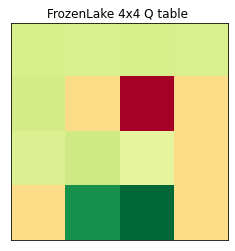

In [120]:
plt.imshow(aaa,  cmap='RdYlGn')
plt.title('FrozenLake 4x4 Q table ')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)


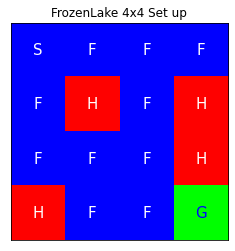

In [114]:
    discrete_map = np.array([[-1,-1,-1,-1],[-1, 0, -1, 0],[-1,-1,-1, 0],[0, -1,-1, 1]])
    
    plt.imshow(discrete_map, cmap='brg')
    plotText = plt.text(0, 0, 'S', ha="center", va="center", color="w", size=15)
    plotText = plt.text(0, 1, 'F', ha="center", va="center", color="w", size=15)
    plotText = plt.text(0, 2, 'F', ha="center", va="center", color="w", size=15)
    plotText = plt.text(0, 3, 'H', ha="center", va="center", color="w", size=15)
    
    plotText = plt.text(1, 0, 'F', ha="center", va="center", color="w", size=15)
    plotText = plt.text(1, 1, 'H', ha="center", va="center", color="w", size=15)
    plotText = plt.text(1, 2, 'F', ha="center", va="center", color="w", size=15)
    plotText = plt.text(1, 3, 'F', ha="center", va="center", color="w", size=15)
    
    plotText = plt.text(2, 0, 'F', ha="center", va="center", color="w", size=15)
    plotText = plt.text(2, 1, 'F', ha="center", va="center", color="w", size=15)
    plotText = plt.text(2, 2, 'F', ha="center", va="center", color="w", size=15)
    plotText = plt.text(2, 3, 'F', ha="center", va="center", color="w", size=15)
    
    plotText = plt.text(3, 0, 'F', ha="center", va="center", color="w", size=15)
    plotText = plt.text(3, 1, 'H', ha="center", va="center", color="w", size=15)
    plotText = plt.text(3, 2, 'H', ha="center", va="center", color="w", size=15)
    plotText = plt.text(3, 3, 'G', ha="center", va="center", color="b", size=15)    
    plt.title('FrozenLake 4x4 Set up')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)